# The Language of Failure

Resource: http://rahul.gopinath.org/post/2020/08/03/simple-ddset/

Also: https://neumorphism.io/#e0e0e0

_Brief abstract/introduction/motivation.  State what the chapter is about in 1-2 paragraphs._
_Then, have an introduction video:_

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* _Refer to earlier chapters as notebooks here, as here:_ [Earlier Chapter](Fuzzer.ipynb).

In [2]:
import bookutils

In [3]:
import DeltaDebugger

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.DDSet import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:

```python
>>> print(int_fuzzer())

45.5
```


## A Failing Program

In [4]:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    # postcondition
    assert '<' not in out and '>' not in out

    return out

In [5]:
from ExpectError import ExpectError

In [6]:
BAD_INPUT = '<foo>"bar</foo>'

In [7]:
with ExpectError(AssertionError):
    remove_html_markup(BAD_INPUT)

Traceback (most recent call last):
  File "<ipython-input-7-491b4345bb53>", line 2, in <module>
    remove_html_markup(BAD_INPUT)
  File "<ipython-input-4-4cc94c1ede06>", line 17, in remove_html_markup
    assert '<' not in out and '>' not in out
AssertionError (expected)


## Grammars

In [8]:
import string

In [9]:
SIMPLE_HTML_GRAMMAR = {
    "<start>":
        ["<html>"],

    "<html>":
        ["<plain-text>", "<tagged-text>"],

    "<plain-text>":
        ["", "<plain-char><plain-text>"],

    "<plain-char>":
        ["<letter>", "<digit>", "<other>"],

    "<tagged-text>":
        ["<opening-tag><html><closing-tag>",
         "<combined-tag>",
         "<opening-tag>"],

    "<opening-tag>":
        ["<lt><id><gt>",
         "<lt><id><attrs><gt>"],

    "<closing-tag>":
        ["<lt>/<id><gt>"],

    "<combined-tag>":
        ["<lt><id><attrs>/<gt>"],

    "<lt>": [ "<" ],
    "<gt>": [ ">" ],

    "<attrs>":
        ["<attr>", "<attr> <attrs>" ],

    "<attr>":
        ["<id>='<plain-text>'",
         '<id>="<plain-text>"'],

    "<id>":
        ["<letter>", "<id><letter>", "<id><digit>"],

    "<letter>": list(string.ascii_letters),
    "<digit>": list(string.digits),
    "<other>": list(string.punctuation.replace('<', '').replace('>', ''))
}

## Fuzzing

In [10]:
from fuzzingbook.GrammarFuzzer import GrammarFuzzer

In [11]:
simple_html_fuzzer = GrammarFuzzer(SIMPLE_HTML_GRAMMAR)

In [12]:
for i in range(20):
    fuzz_html = simple_html_fuzzer.fuzz()
    print(repr(fuzz_html))

''
'<wQ>'
'k'
''
'<YSz83=":"></J1rs5>'
'<YM6I=\'u\'><nF="" h="" k=\'\'></Y9>'
'<y>'
''
''
'<V2><yWh></VC>'
'a'
'<L420Y6hehp="" n=\'6\'/>'
'0^J'
'<Ho4nJX="" C=\'\' Gs=\'\'/>'
'P'
'<VRrP="">'
'<XU>'
'H'
''
'<B2M="I" TI8w6=\'a01\'/>'


## Derivation Trees

In [13]:
from fuzzingbook.Parser import display_tree

In [14]:
fuzz_html

'<B2M="I" TI8w6=\'a01\'/>'

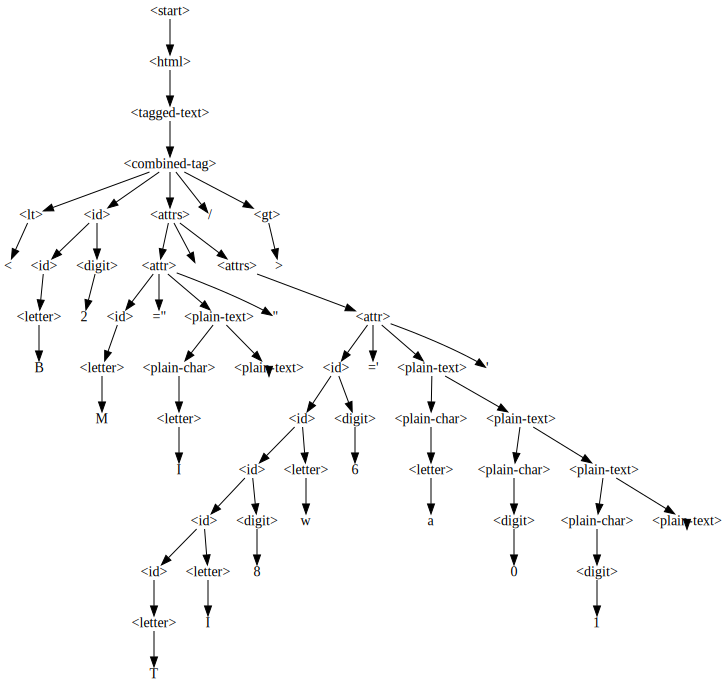

In [15]:
display_tree(simple_html_fuzzer.derivation_tree)

## Parsing

In [16]:
from fuzzingbook.Parser import EarleyParser

In [17]:
simple_html_parser = EarleyParser(SIMPLE_HTML_GRAMMAR)

In [18]:
bad_input_tree = list(simple_html_parser.parse(BAD_INPUT))[0]

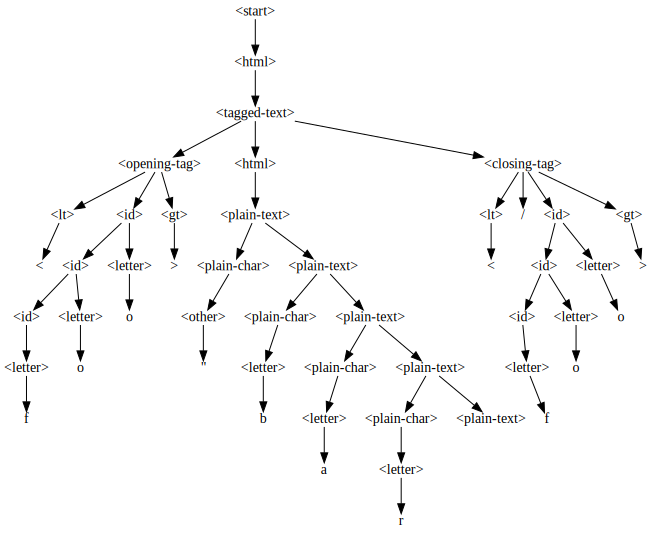

In [19]:
display_tree(bad_input_tree)

In [20]:
from fuzzingbook.GrammarFuzzer import tree_to_string, all_terminals

In [21]:
tree_to_string(bad_input_tree)

'<foo>"bar</foo>'

## Mutating the Tree

In [22]:
from fuzzingbook.Grammars import is_valid_grammar

In [23]:
class TreeMutator:
    def __init__(self, grammar, tree, log=False):
        assert is_valid_grammar(grammar)
        self.grammar = grammar
        self.tree = tree
        self.log = log

In [24]:
class TreeMutator(TreeMutator):
    def get_subtree(self, path, tree=None):
        if tree is None:
            tree = self.tree

        node, children = tree

        if not path:
            return tree

        return self.get_subtree(path[1:], children[path[0]])

In [25]:
def bad_input_tree_mutator():
    return TreeMutator(SIMPLE_HTML_GRAMMAR, bad_input_tree, log=2)    

In [26]:
bad_input_tree_mutator().get_subtree([0, 0, 1, 0])

('<plain-text>',
 [('<plain-char>', [('<other>', [('"', [])])]),
  ('<plain-text>',
   [('<plain-char>', [('<letter>', [('b', [])])]),
    ('<plain-text>',
     [('<plain-char>', [('<letter>', [('a', [])])]),
      ('<plain-text>',
       [('<plain-char>', [('<letter>', [('r', [])])]),
        ('<plain-text>', [])])])])])

In [27]:
class TreeMutator(TreeMutator):
    def new_tree(self, start_symbol):
        if self.log >= 2:
            print(f"Creating new tree for {start_symbol}")

        fuzzer = GrammarFuzzer(self.grammar, start_symbol=start_symbol)
        fuzzer.fuzz()
        return fuzzer.derivation_tree

In [28]:
bad_input_tree_mutator().new_tree('<plain-text>')

Creating new tree for <plain-text>


('<plain-text>',
 [('<plain-char>', [('<letter>', [('o', [])])]), ('<plain-text>', [('', [])])])

In [29]:
class TreeMutator(TreeMutator):
    def mutate(self, path, tree=None):
        if tree is None:
            tree = self.tree

        node, children = tree

        if not path:
            return self.new_tree(node)

        head = path[0]
        new_children = (children[:head] +
                        [self.mutate(path[1:], children[head])] +
                        children[head + 1:])
        return node, new_children

In [30]:
bad_input_tree_mutator().mutate([0])

Creating new tree for <html>


('<start>',
 [('<html>',
   [('<plain-text>',
     [('<plain-char>', [('<other>', [('*', [])])]),
      ('<plain-text>',
       [('<plain-char>', [('<other>', [('~', [])])]),
        ('<plain-text>', [('', [])])])])])])

In [31]:
tree_to_string(bad_input_tree_mutator().mutate([0, 0, 1, 0]))

Creating new tree for <plain-text>


'<foo></foo>'

## Generalizing Trees

In [32]:
class TreeGeneralizer(TreeMutator):
    def __init__(self, grammar, tree, test,
                 max_tries_for_abstraction=10,
                 **kwargs):
        super().__init__(grammar, tree, **kwargs)
        self.test = test
        self.max_tries_for_abstraction = max_tries_for_abstraction

In [33]:
class TreeGeneralizer(TreeGeneralizer):
    def test_tree(self, tree):
        s = tree_to_string(tree)
        if self.log:
            print(f"Testing {repr(s)}...", end="")
        try:
            self.test(s)
        except Exception as exc:
            if self.log:
                print(f"FAIL ({type(exc).__name__})")
            ret = False
        else:
            if self.log:
                print(f"PASS")
            ret = True

        return ret

In [34]:
class TreeGeneralizer(TreeGeneralizer):
    def can_generalize(self, path, tree=None):
        for i in range(self.max_tries_for_abstraction):
            mutated_tree = self.mutate(path, tree)
            if self.test_tree(mutated_tree):
                # Failure no longer occurs; cannot abstract
                return False
            
        return True

In [35]:
def bad_input_tree_generalizer():
    return TreeGeneralizer(SIMPLE_HTML_GRAMMAR, bad_input_tree,
                           remove_html_markup, log=True)    

In [36]:
bad_input_tree_generalizer().can_generalize([0])

Testing '<M16oN6XM="10-" o="" j=\']\'/>'...PASS


False

In [37]:
bad_input_tree_generalizer().can_generalize([0, 0, 1, 0])

Testing '<foo></foo>'...PASS


False

In [38]:
bad_input_tree_generalizer().can_generalize([0, 0, 0])

Testing '<u03p=\'p\' x=\'I\'>"bar</foo>'...FAIL (AssertionError)
Testing '<RE7=":">"bar</foo>'...FAIL (AssertionError)
Testing '<Yg683yqI85=\'O\' c5="@" f=\'\' k=\'\'>"bar</foo>'...FAIL (AssertionError)
Testing '<n145>"bar</foo>'...FAIL (AssertionError)
Testing '<t5A2ARYuZ0Z3>"bar</foo>'...FAIL (AssertionError)
Testing '<z>"bar</foo>'...FAIL (AssertionError)
Testing '<Up6BSTKR7G61=\'8n\'>"bar</foo>'...FAIL (AssertionError)
Testing '<Wi77v="$">"bar</foo>'...FAIL (AssertionError)
Testing '<n5>"bar</foo>'...FAIL (AssertionError)
Testing '<RVvwSrC0=\'\'>"bar</foo>'...FAIL (AssertionError)


True

In [39]:
class TreeGeneralizer(TreeGeneralizer):
    def find_paths(self, predicate, path=None, tree=None):
        if path is None:
            path = []
        if tree is None:
            tree = self.tree
            
        node, children = self.get_subtree(path)

        if predicate(path, tree):
            if self.log:
                node, children = self.get_subtree(path)
            return [path]

        paths = []
        for i, child in enumerate(children):
            child_node, _ = child
            if child_node in self.grammar:
                paths += self.find_paths(predicate, path + [i])

        return paths        
    
    def generalizable_paths(self):
        return self.find_paths(self.can_generalize)

In [40]:
bad_input_tree_generalizer().generalizable_paths()

Testing 'P'...PASS
Testing 'o'...PASS
Testing '<lW="5.2" F62=\'\'><c90></P>'...PASS
Testing '<u>"bar</foo>'...FAIL (AssertionError)
Testing '<wZ>"bar</foo>'...FAIL (AssertionError)
Testing '<eY=\'nX\' i=\'1\'>"bar</foo>'...FAIL (AssertionError)
Testing '<PH9vbT8g4e4=\'\' y2=\'rw}^B2\' G2678g3="">"bar</foo>'...FAIL (AssertionError)
Testing '<wmy08VX9133N="2" r=\'0!!#1\'>"bar</foo>'...FAIL (AssertionError)
Testing '<t7ZyR="">"bar</foo>'...FAIL (AssertionError)
Testing '<w4rSO6iCir=\']\' v3="">"bar</foo>'...FAIL (AssertionError)
Testing '<h16vk>"bar</foo>'...FAIL (AssertionError)
Testing '<a6GT9=\'\'>"bar</foo>'...FAIL (AssertionError)
Testing '<y1JGcbe=\'8k\' AYb29=\'\' P5f=\'3,e\'>"bar</foo>'...FAIL (AssertionError)
Testing '<foo>Z</foo>'...PASS
Testing '<foo>4</foo>'...PASS
Testing '<foo>Zbar</foo>'...PASS
Testing '<foo>=bar</foo>'...PASS
Testing '<foo>"</foo>'...FAIL (AssertionError)
Testing '<foo>"P</foo>'...FAIL (AssertionError)
Testing '<foo>"$4</foo>'...FAIL (AssertionError)
Testi

[[0, 0, 0], [0, 0, 1, 0, 1], [0, 0, 2]]

In [41]:
class TreeGeneralizer(TreeGeneralizer):
    def generalize_path(self, path, tree=None):
        if tree is None:
            tree = self.tree

        node, children = tree

        if not path:
            return node, []

        head = path[0]
        new_children = (children[:head] +
                        [self.generalize_path(path[1:], children[head])] +
                        children[head + 1:])
        return node, new_children

In [42]:
all_terminals(bad_input_tree_generalizer().generalize_path([0, 0, 0]))

'<opening-tag>"bar<plain-text></foo>'

In [43]:
class TreeGeneralizer(TreeGeneralizer):
    def generalize(self):
        tree = self.tree
        for path in self.generalizable_paths():
            tree = self.generalize_path(path, tree)
            
        return tree

In [44]:
all_terminals(bad_input_tree_generalizer().generalize())

Testing ''...PASS
Testing ''...PASS
Testing '<dz>'...PASS
Testing '<N>"bar</foo>'...FAIL (AssertionError)
Testing '<I>"bar</foo>'...FAIL (AssertionError)
Testing '<GGj98IC04>"bar</foo>'...FAIL (AssertionError)
Testing '<HC5>"bar</foo>'...FAIL (AssertionError)
Testing '<X>"bar</foo>'...FAIL (AssertionError)
Testing '<A005>"bar</foo>'...FAIL (AssertionError)
Testing '<D>"bar</foo>'...FAIL (AssertionError)
Testing '<n9n2C=\'5\'>"bar</foo>'...FAIL (AssertionError)
Testing '<K>"bar</foo>'...FAIL (AssertionError)
Testing '<n54d>"bar</foo>'...FAIL (AssertionError)
Testing '<foo></foo>'...PASS
Testing '<foo>W</foo>'...PASS
Testing '<foo>sbar</foo>'...PASS
Testing '<foo>{bar</foo>'...PASS
Testing '<foo>"3</foo>'...FAIL (AssertionError)
Testing '<foo>"4</foo>'...FAIL (AssertionError)
Testing '<foo>"</foo>'...FAIL (AssertionError)
Testing '<foo>"F7</foo>'...FAIL (AssertionError)
Testing '<foo>"y1</foo>'...FAIL (AssertionError)
Testing '<foo>"-</foo>'...FAIL (AssertionError)
Testing '<foo>"5</foo>

'<opening-tag>"<plain-text><closing-tag>'

## Putting it all Together

In [45]:
from DeltaDebugger import CallCollector, is_reducible

In [46]:
import copy

In [47]:
class DDSetDebugger(CallCollector):
    def __init__(self, grammar, 
                 generalizer=TreeGeneralizer,
                 parser=EarleyParser,
                 **kwargs):
        super().__init__(**kwargs)
        self.grammar = grammar
        self.parser = parser(grammar)
        self.generalizer = generalizer

    def generalized_args(self, **kwargs):
        generalized_args = copy.deepcopy(self.args())

        for arg in self.args():
            def test(value):
                return self.call({arg: value})

            value = self.args()[arg]
            if is_reducible(value):
                tree = list(self.parser.parse(value))[0]
                gen = self.generalizer(self.grammar, tree, test, **kwargs)
                generalized_args[arg] = all_terminals(gen.generalize())

        return generalized_args

In [48]:
with DDSetDebugger(SIMPLE_HTML_GRAMMAR) as dd:
    remove_html_markup(BAD_INPUT)

In [49]:
dd.generalized_args()['s']

'<opening-tag>"<plain-text><closing-tag>'

## More Examples

### Square Root

In [50]:
from Assertions import square_root

In [51]:
INT_GRAMMAR = {
    "<start>":
        ["<int>"],

    "<int>":
        ["<positive-int>", "-<positive-int>"],

    "<positive-int>":
        ["<digit>", "<nonzero-digit><positive-int>"],

    "<nonzero-digit>": list("123456789"),
    
    "<digit>": list(string.digits),
}

In [52]:
def square_root_test(s):
    return square_root(int(s))

In [53]:
with DDSetDebugger(INT_GRAMMAR) as dd:
    square_root_test("-1")

In [54]:
dd.generalized_args(log=True)['s']

Testing '-4'...FAIL (AssertionError)
Testing '-12'...FAIL (AssertionError)
Testing '-4'...FAIL (AssertionError)
Testing '2'...PASS
Testing '82'...PASS
Testing '-6'...FAIL (AssertionError)
Testing '-1'...FAIL (AssertionError)
Testing '-32'...FAIL (AssertionError)
Testing '-9'...FAIL (AssertionError)
Testing '-60'...FAIL (AssertionError)
Testing '-8'...FAIL (AssertionError)
Testing '-3'...FAIL (AssertionError)
Testing '-63'...FAIL (AssertionError)
Testing '-7'...FAIL (AssertionError)
Testing '-20'...FAIL (AssertionError)


'-<positive-int>'

### Middle

In [55]:
from StatisticalDebugger import middle

In [56]:
XYZ_GRAMMAR = {
    "<start>":
        ["<int>, <int>, <int>"],

    "<int>":
        ["<positive-int>", "-<positive-int>"],

    "<positive-int>":
        ["<digit>", "<nonzero-digit><positive-int>"],

    "<nonzero-digit>": list("123456789"),
    
    "<digit>": list(string.digits),
}

In [57]:
def middle_test(s):
    x, y, z = eval(s)
    assert middle(x, y, z) == sorted([x, y, z])[1]

In [58]:
with ExpectError(AssertionError):
    middle_test("2, 1, 3")

Traceback (most recent call last):
  File "<ipython-input-58-66d8f3f75b66>", line 2, in <module>
    middle_test("2, 1, 3")
  File "<ipython-input-57-f901d04f7750>", line 3, in middle_test
    assert middle(x, y, z) == sorted([x, y, z])[1]
AssertionError (expected)


In [59]:
with DDSetDebugger(XYZ_GRAMMAR) as dd:
    middle_test("2, 1, 3")

In [60]:
dd.generalized_args(log=True)['s']

Testing '9, 6140, 5'...PASS
Testing '32, 1, 3'...PASS
Testing '53, 1, 3'...PASS
Testing '1, 1, 3'...PASS
Testing '2, 84, 3'...PASS
Testing '2, 1, 3'...FAIL (AssertionError)
Testing '2, 9, 3'...PASS
Testing '2, 7, 3'...PASS
Testing '2, 1, -9'...PASS
Testing '2, 1, 5'...FAIL (AssertionError)
Testing '2, 1, 24'...FAIL (AssertionError)
Testing '2, 1, 58'...FAIL (AssertionError)
Testing '2, 1, 843'...FAIL (AssertionError)
Testing '2, 1, 3'...FAIL (AssertionError)
Testing '2, 1, 168'...FAIL (AssertionError)
Testing '2, 1, 0'...PASS
Testing '2, 1, 2'...PASS


'2, 1, 3'

# Synopsis

<!-- Automatically generated. Do not edit. -->



_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:

```python
print(int_fuzzer())
```
```python
=> 76.5

```


## _Section 1_

\todo{Add}

## _Section 2_

\todo{Add}

### Excursion: All the Details

This text will only show up on demand (HTML) or not at all (PDF). This is useful for longer implementations, or repetitive, or specialized parts.

### End of Excursion

## _Section 3_

\todo{Add}

_If you want to introduce code, it is helpful to state the most important functions, as in:_

* `random.randrange(start, end)` - return a random number [`start`, `end`]
* `range(start, end)` - create a list with integers from `start` to `end`.  Typically used in iterations.
* `for elem in list: body` executes `body` in a loop with `elem` taking each value from `list`.
* `for i in range(start, end): body` executes `body` in a loop with `i` from `start` to `end` - 1.
* `chr(n)` - return a character with ASCII code `n`

In [61]:
import random

In [62]:
def int_fuzzer():
    """A simple function that returns a random integer"""
    return random.randrange(1, 100) + 0.5

In [63]:
# More code
pass

## _Section 4_

\todo{Add}

## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:

In [64]:
print(int_fuzzer())

45.5


## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [65]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [66]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_

## Reducing Trees

In [67]:
from DeltaDebugger import DeltaDebugger

In [68]:
import copy

In [69]:
from IPython.display import display

In [70]:
class TreeHDDReducer(TreeGeneralizer):
    def _reduce(self, path, tree):
        """This is HDD"""

        node, children = self.get_subtree(path, tree)
            
        if len(path) >= 1:
            parent, parent_children = self.get_subtree(path[:-1], tree)
 
            assert parent_children[path[-1]] == (node, children)

            def test_children(children):
                parent_children[path[-1]] = (node, children)
                s = tree_to_string(tree)
                self.test(s)

            with DeltaDebugger() as dd:
                test_children(children)
            
            # display(display_tree(tree))

            children = dd.min_args()['children']
            parent_children[path[-1]] = (node, children)
        
        for i, child in enumerate(children):
            self._reduce(path + [i], tree)
            
        return tree

    def reduce(self):
        return self._reduce([], self.tree)

In [71]:
def bad_input_tree_hdd_reducer():
    return TreeHDDReducer(SIMPLE_HTML_GRAMMAR, copy.deepcopy(bad_input_tree),
                       remove_html_markup, log=True)    

In [72]:
all_terminals(bad_input_tree_hdd_reducer().reduce())

'"<'

## More Reducing Trees

In [73]:
class TreeReducer(TreeGeneralizer):
    def new_min_tree(self, start_symbol):
        if self.log >= 2:
            print(f"Creating new minimal tree for {start_symbol}")

        fuzzer = GrammarFuzzer(self.grammar, start_symbol=start_symbol,
                               min_nonterminals=0,
                               max_nonterminals=0)
        fuzzer.fuzz()
        return fuzzer.derivation_tree

In [74]:
def bad_input_tree_reducer():
    return TreeReducer(SIMPLE_HTML_GRAMMAR, bad_input_tree,
                       remove_html_markup, log=2)    

In [75]:
tree_to_string(bad_input_tree_reducer().new_min_tree('<start>'))

Creating new minimal tree for <start>


''

In [76]:
class TreeReducer(TreeReducer):
    def reduce_path(self, path, tree=None):
        if tree is None:
            tree = self.tree

        node, children = tree

        if not path:
            return self.new_min_tree(node)

        head = path[0]
        new_children = (children[:head] +
                        [self.reduce_path(path[1:], children[head])] +
                        children[head + 1:])
        return node, new_children

In [77]:
tree_to_string(bad_input_tree_reducer().reduce_path([0, 0, 1, 0]))

Creating new minimal tree for <plain-text>


'<foo></foo>'

In [78]:
class TreeReducer(TreeReducer):
    def can_reduce(self, path, tree=None):
        reduced_tree = self.reduce_path(path, tree)
        if self.test_tree(reduced_tree):
            # Failure no longer occurs; cannot reduce
            return False

        return True

In [79]:
class TreeReducer(TreeReducer):
    def reducible_paths(self):
        return self.find_paths(self.can_reduce)

In [80]:
bad_input_tree_reducer().reducible_paths()

Creating new minimal tree for <start>
Testing ''...PASS
Creating new minimal tree for <html>
Testing ''...PASS
Creating new minimal tree for <tagged-text>
Testing '<Z>'...PASS
Creating new minimal tree for <opening-tag>
Testing '<p>"bar</foo>'...FAIL (AssertionError)
Creating new minimal tree for <html>
Testing '<foo></foo>'...PASS
Creating new minimal tree for <plain-text>
Testing '<foo></foo>'...PASS
Creating new minimal tree for <plain-char>
Testing '<foo>.bar</foo>'...PASS
Creating new minimal tree for <other>
Testing '<foo>;bar</foo>'...PASS
Creating new minimal tree for <plain-text>
Testing '<foo>"</foo>'...FAIL (AssertionError)
Creating new minimal tree for <closing-tag>
Testing '<foo>"bar</Y>'...FAIL (AssertionError)


[[0, 0, 0], [0, 0, 1, 0, 1], [0, 0, 2]]

In [81]:
class TreeReducer(TreeReducer):
    def reduce(self):
        tree = self.tree
        for path in self.reducible_paths():
            tree = self.reduce_path(path, tree)
            
        return tree

In [82]:
all_terminals(bad_input_tree_reducer().reduce())

Creating new minimal tree for <start>
Testing ''...PASS
Creating new minimal tree for <html>
Testing ''...PASS
Creating new minimal tree for <tagged-text>
Testing '<a>'...PASS
Creating new minimal tree for <opening-tag>
Testing '<W>"bar</foo>'...FAIL (AssertionError)
Creating new minimal tree for <html>
Testing '<foo></foo>'...PASS
Creating new minimal tree for <plain-text>
Testing '<foo></foo>'...PASS
Creating new minimal tree for <plain-char>
Testing '<foo>lbar</foo>'...PASS
Creating new minimal tree for <other>
Testing '<foo>.bar</foo>'...PASS
Creating new minimal tree for <plain-text>
Testing '<foo>"</foo>'...FAIL (AssertionError)
Creating new minimal tree for <closing-tag>
Testing '<foo>"bar</r>'...FAIL (AssertionError)
Creating new minimal tree for <opening-tag>
Creating new minimal tree for <plain-text>
Creating new minimal tree for <closing-tag>


'<E>"</l>'